In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
use_cuda = True
device = torch.device('cuda:4' if use_cuda else 'cpu')

# 1、Generate some elementary functions

In [3]:
t = np.linspace(0.001,3,1000)
# Trigonometric functions
S_sin = np.sin(2*np.pi*2*t) #sine
S_cos = np.cos(2*np.pi*2*t) #cosine
# power function
S_x = t
S_x2 = t**2
S_x3 = t**3
S_x0_5 = t**0.5
S_x0_25 = t**0.25
S_xn1 = 1/S_x
S_xn2 = 1/S_x2
S_xn3 = 1/S_x3
S_xn0_5 = 1/S_x0_5
S_xn0_25 = 1/S_x0_25
# Logarithmic functions
S_log = np.log(t)
S_log2 = np.log2(t)
S_log10 = np.log10(t)
# Exponential functions
S_base2 = 2**t
S_basee = np.e**t
S_base10 = 10**t

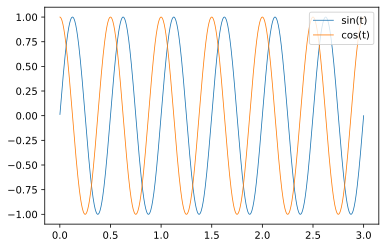

In [4]:
plt.plot(t,S_sin,linewidth = 0.8,label = 'sin(t)')
plt.plot(t,S_cos,linewidth = 0.8,label = 'cos(t)')
plt.legend(loc='upper right')
plt.show()

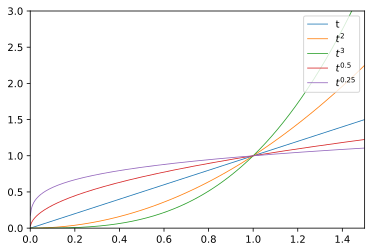

In [5]:
plt.plot(t,S_x,linewidth = 0.8,label = 't')
plt.plot(t,S_x2,linewidth = 0.8,label = '$t^2$')
plt.plot(t,S_x3,linewidth = 0.8,label = '$t^3$')
plt.plot(t,S_x0_5,linewidth = 0.8,label = '$t^{0.5}$')
plt.plot(t,S_x0_25,linewidth = 0.8,label = '$t^{0.25}$')
plt.xlim([0,1.5])
plt.ylim([0,3])
plt.legend(loc='upper right')
plt.show()

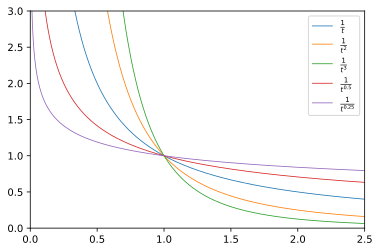

In [6]:
plt.plot(t,S_xn1,linewidth = 0.8,label = r'$\frac{1}{t}$')
plt.plot(t,S_xn2,linewidth = 0.8,label = r'$\frac{1}{t^2}$')
plt.plot(t,S_xn3,linewidth = 0.8,label = r'$\frac{1}{t^3}$')
plt.plot(t,S_xn0_5,linewidth = 0.8,label = r'$\frac{1}{t^{0.5}}$')
plt.plot(t,S_xn0_25,linewidth = 0.8,label = r'$\frac{1}{t^{0.25}}$')
plt.xlim([0,2.5])
plt.ylim([0,3])
plt.legend(loc='upper right')
plt.show()

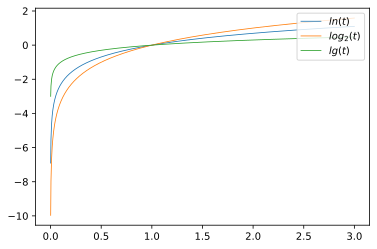

In [7]:
plt.plot(t,S_log,linewidth = 0.8,label = r'$ln(t)}$')
plt.plot(t,S_log2,linewidth = 0.8,label = r'$log_2(t)}$')
plt.plot(t,S_log10,linewidth = 0.8,label = r'$lg(t)}$')
plt.legend(loc='upper right')
plt.show()

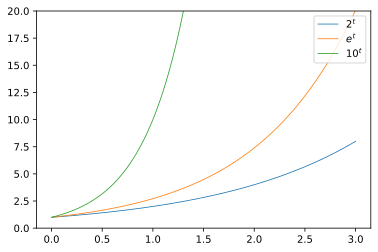

In [8]:
plt.plot(t,S_base2,linewidth = 0.8,label = r'$2^t$')
plt.plot(t,S_basee,linewidth = 0.8,label = r'$e^t$')
plt.plot(t,S_base10,linewidth = 0.8,label = r'$10^t$')
plt.ylim([0,20])
plt.legend(loc='upper right')
plt.show()

# 2、Data set and Data loader: Using sine function $sin(2{\pi}fx)+n(x)$ to fit $sin(2{\pi}fx)$

In [9]:
class SineDataSet(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels):
        super(SineDataSet,self).__init__()
        self.data = torch.Tensor(data)
        self.labels = torch.Tensor(labels)
        self.length = len(data)
    
    def __getitem__(self, index):
        data = self.data[index:index+1].transpose(0,1)
        labels = self.labels[index:index+1]
        return data, labels
        
    def __len__(self):
        return self.length

In [10]:
phase_train = np.linspace(0,2*np.pi,60000).reshape(-1,1)
phase_test = np.linspace(0,2*np.pi,10000).reshape(-1,1)

In [11]:
t = np.linspace(0.001,3,1000).reshape(1,-1)
# Trigonometric functions
S_sin = np.sin(2*np.pi*2*t) #sine
S_cos = np.cos(2*np.pi*2*t) #cosine
S = np.vstack((S_sin,S_cos))

Theta_sin = np.sin(phase_train)
Theta_cos = np.cos(phase_train)
Theta = np.hstack((Theta_cos,Theta_sin))
data_train_target = np.matmul(Theta,S)
data_train_noise = data_train_target + 0.3*np.random.randn(*data_train_target.shape)

Theta_sin = np.sin(phase_test)
Theta_cos = np.cos(phase_test)
Theta = np.hstack((Theta_cos,Theta_sin))
data_test_target = np.matmul(Theta,S)
data_test_noise = data_test_target + 0.3*np.random.randn(*data_test_target.shape)


In [12]:
data_train_target.shape

(60000, 1000)

In [13]:
data_train = SineDataSet(data_train_noise, data_train_target)
data_test = SineDataSet(data_test_noise, data_test_target)

In [14]:
dataLoader_train = torch.utils.data.DataLoader(
    dataset = data_train,
    batch_size = 128,
    shuffle = True,
)

In [15]:
dataLoader_test = torch.utils.data.DataLoader(
    dataset = data_test,
    batch_size = 128,
    shuffle = True,
)

In [16]:
x,y = iter(dataLoader_train).next()
x.shape

torch.Size([128, 1000, 1])

In [17]:
y.shape

torch.Size([128, 1, 1000])

# 3、LSTM or GRU model

In [18]:
class LSTMRegression(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 1):
        super(LSTMRegression, self).__init__()
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
        )
        # use convolution neural networks to accelerate
        self.conv1 = nn.Conv1d(
            in_channels = input_size,
            out_channels = 128,
            kernel_size = hidden_size,
            stride = hidden_size,
        )
        self.conv2 = nn.Conv1d(
            in_channels = 128,
            out_channels = input_size,
            kernel_size = 1,
            stride = 1,
        )
    
    def forward(self, x, state = None):
        y, state = self.lstm(x,state) # lstm
        y = y.contiguous().view(y.shape[0],1,-1) # flatten
        y = self.conv1(y)
        y = self.conv2(y)
        return y, state

In [19]:
class GRURegression(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 1):
        super(GRURegression, self).__init__()
        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
        )
        # use convolution neural networks to accelerate
        self.conv1 = nn.Conv1d(
            in_channels = input_size,
            out_channels = 128,
            kernel_size = hidden_size,
            stride = hidden_size,
        )
        self.conv2 = nn.Conv1d(
            in_channels = 128,
            out_channels = input_size,
            kernel_size = 1,
            stride = 1,
        )
    
    def forward(self, x, state = None):
        y, state = self.gru(x,state) # lstm
        y = y.contiguous().view(y.shape[0],1,-1) # flatten
        y = self.conv1(y)
        y = self.conv2(y)
        return y, state

In [20]:
myLSTMRegression = LSTMRegression()
myLSTMRegression.cpu()

LSTMRegression(
  (lstm): LSTM(1, 32, batch_first=True)
  (conv1): Conv1d(1, 128, kernel_size=(32,), stride=(32,))
  (conv2): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
)

In [21]:
myGRURegression = GRURegression()
myGRURegression.cpu()

GRURegression(
  (gru): GRU(1, 32, batch_first=True)
  (conv1): Conv1d(1, 128, kernel_size=(32,), stride=(32,))
  (conv2): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
)

In [22]:
x = torch.zeros(3,1000,1) + 1
y, state = myLSTMRegression(x)
y, state = myGRURegression(x)

In [23]:
x,y = iter(dataLoader_train).next()
x.shape

torch.Size([128, 1000, 1])

In [24]:
y_, state = myLSTMRegression(x)

In [25]:
y_.shape

torch.Size([128, 1, 1000])

In [26]:
y.shape

torch.Size([128, 1, 1000])

# 4、training process

In [27]:
optimizerLSTM = optim.Adam(myLSTMRegression.parameters(),lr = 0.001,)
optimizerGRU = optim.Adam(myGRURegression.parameters(),lr = 0.001,)

In [28]:
loss_func = nn.MSELoss()

In [29]:
myLSTMRegression.to(device)
myGRURegression.to(device)

GRURegression(
  (gru): GRU(1, 32, batch_first=True)
  (conv1): Conv1d(1, 128, kernel_size=(32,), stride=(32,))
  (conv2): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
)

In [30]:
%%time
myLSTMRegression.train()
for epoch in range(5):
    for step,(x,y) in enumerate(dataLoader_train):
        x = x.cuda(device)
        y = y.cuda(device)
        y_,state = myLSTMRegression(x)
        loss = loss_func(y_,y)
        
        optimizerLSTM.zero_grad()
        loss.backward()
        optimizerLSTM.step()

        print('\repoch:{epoch:3}--step:{step:5}--loss:{loss:.4}'.format(epoch = epoch, step=step, loss=loss),end = '')
#     print('\repoch:{epoch:3}--step:{step:5}--loss:{loss:.4}--acc:{acc:.4}%-----'.format(epoch = epoch, step=step, loss=loss, acc = acc/10000*100))
    print()

epoch:  0--step:  468--loss:0.006169
epoch:  1--step:  468--loss:0.004939
epoch:  2--step:  468--loss:0.004179
epoch:  3--step:  468--loss:0.003494
epoch:  4--step:  468--loss:0.002504
CPU times: user 10min 4s, sys: 42.8 s, total: 10min 47s
Wall time: 10min 36s


In [31]:
%%time
myGRURegression.train()
for epoch in range(5):
    for step,(x,y) in enumerate(dataLoader_train):
        x = x.cuda(device)
        y = y.cuda(device)
        y_,state = myGRURegression(x)
        loss = loss_func(y_,y)
        
        optimizerGRU.zero_grad()
        loss.backward()
        optimizerGRU.step()

        print('\repoch:{epoch:3}--step:{step:5}--loss:{loss:.4}'.format(epoch = epoch, step=step, loss=loss),end = '')
#     print('\repoch:{epoch:3}--step:{step:5}--loss:{loss:.4}--acc:{acc:.4}%-----'.format(epoch = epoch, step=step, loss=loss, acc = acc/10000*100))
    print()

epoch:  0--step:  468--loss:0.005699
epoch:  1--step:  468--loss:0.003183
epoch:  2--step:  468--loss:0.002341
epoch:  3--step:  468--loss:0.001688
epoch:  4--step:  468--loss:0.001639
CPU times: user 9min 30s, sys: 32 s, total: 10min 2s
Wall time: 9min 53s


In [32]:
x,y = iter(dataLoader_test).next()
x = x.cuda(device)
y = y.cuda(device)
y_1,state = myLSTMRegression(x)
y_2,state = myGRURegression(x)

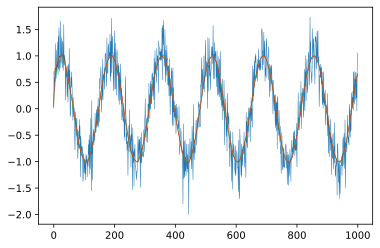

In [33]:
plt.plot(x[50][:,0].detach().cpu().numpy(),linewidth = 0.5)
plt.plot(y[50][0].detach().cpu().numpy(),linewidth = 0.5)
plt.plot(y_1[50][0].detach().cpu().numpy(),linewidth = 0.5)
plt.plot(y_2[50][0].detach().cpu().numpy(),linewidth = 0.5)

# 5、Comparing with CNNs

In [34]:
class CNN(nn.Module):
    def __init__(self, input_size = 1):
        super(CNN, self).__init__()
        # input shape (batch, channel, seq_size)
        self.conv1 = nn.Conv1d(
            in_channels = input_size,
            out_channels = 32,
            kernel_size = 3,
            stride = 2,
            padding = 0,
        )
        self.conv2 = nn.Conv1d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = 3,
            stride = 2,
            padding = 0,
        )
        self.conv3 = nn.Conv1d(
            in_channels = 64,
            out_channels = 128,
            kernel_size = 3,
            stride = 2,
            padding = 0,
        )
        self.conv4 = nn.Conv1d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 2,
            padding = 0,
        )
        self.conv5 = nn.Conv1d(
            in_channels = 256,
            out_channels = 512,
            kernel_size = 3,
            stride = 2,
            padding = 0,
        )
        self.conv6 = nn.Conv1d(
            in_channels = 512,
            out_channels = 1000,
            kernel_size = 1,
            stride = 1,
            padding = 0,
        )
        self.pooling = nn.MaxPool1d(
            kernel_size = 2,
            stride = 2,
        )
        self.activate = nn.ReLU()
        
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = self.activate(x)
        x = self.pooling(x)
        
        x = self.conv2(x)
        x = self.activate(x)
        x = self.pooling(x)
        
        x = self.conv3(x)
        x = self.activate(x)
        x = self.pooling(x)
        
        x = self.conv4(x)
        x = self.activate(x)
        x = self.pooling(x)
        
        x = self.conv5(x)
        x = self.activate(x)
        
        x = self.conv6(x)
#         x = self.pooling(x)
#         x = self.activate(x)
        return x

In [35]:
mycnn = CNN()
mycnn.to(device)

CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(2,))
  (conv5): Conv1d(256, 512, kernel_size=(3,), stride=(2,))
  (conv6): Conv1d(512, 1000, kernel_size=(1,), stride=(1,))
  (pooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activate): ReLU()
)

In [36]:
optimizerCNN = optim.Adam(mycnn.parameters(),lr = 0.001,)
loss_func = nn.MSELoss()

In [37]:
%%time
mycnn.train()
for epoch in range(5):
    for step,(x,y) in enumerate(dataLoader_train):
        x = x.cuda(device)
        y = y.cuda(device).transpose(1,2)
        y_ = mycnn(x)
        loss = loss_func(y_,y)
        
        optimizerCNN.zero_grad()
        loss.backward()
        optimizerCNN.step()

        print('\repoch:{epoch:3}--step:{step:5}--loss:{loss:.4}'.format(epoch = epoch, step=step, loss=loss),end = '')
#     print('\repoch:{epoch:3}--step:{step:5}--loss:{loss:.4}--acc:{acc:.4}%-----'.format(epoch = epoch, step=step, loss=loss, acc = acc/10000*100))
    print()

epoch:  0--step:  468--loss:0.0003519
epoch:  1--step:  468--loss:0.0002198
epoch:  2--step:  468--loss:0.0003035
epoch:  3--step:  468--loss:0.0002049
epoch:  4--step:  468--loss:0.0002797
CPU times: user 1min 25s, sys: 9.3 s, total: 1min 34s
Wall time: 1min 33s


In [38]:
x,y = iter(dataLoader_test).next()
x = x.cuda(device)
y = y.cuda(device).transpose(1,2)
y_ = mycnn(x)

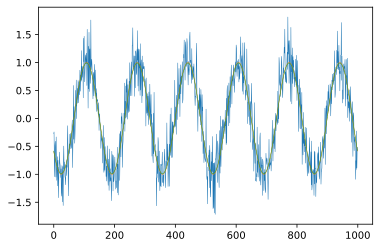

In [39]:
plt.plot(x[50][:,0].detach().cpu().numpy(),linewidth = 0.5)
plt.plot(y[50][:,0].detach().cpu().numpy(),linewidth = 0.5)
plt.plot(y_[50][:,0].detach().cpu().numpy(),linewidth = 0.5)

In [40]:
(2*60+33-34)/34

3.5

# 6、conclusion

<font face="Times New Roman" >It's not necessary to use RNN algorithm to implement a Regression task when all the sequences are available! For the CNN model runs 350% faster than RNN model and have the same low loss. </font>